**Setup of the Jupyter Notebook Environment**

In [1]:
import os
import time
import glob
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed

In [3]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu').type

# init deterministic GPU and CPU seed
torch.manual_seed(seed_value) # set pytorch seed

# log type of device enabled

print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [4]:
!nvidia-smi

Tue Jan 27 12:27:50 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# check whether directory exists
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/SalmonScan'))

['Raw', 'Augmented', 'best_salmon_model.pth']


**Preparing the dataset**

In [7]:
# list all images files
main_dir = '/content/drive/MyDrive/Colab Notebooks/SalmonScan'

image_paths = glob.glob(os.path.join(main_dir, '**', '*.jpg'), recursive=True)
image_paths += glob.glob(os.path.join(main_dir, '**', '*.png'), recursive=True)

print(f"Found {len(image_paths)} images.")
print("Sample paths:", image_paths[:3])  # Print first 3 paths as a sample

Found 1322 images.
Sample paths: ['/content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_16.png', '/content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_01.png', '/content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_14.png']


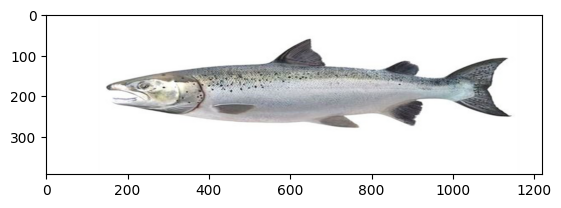

In [8]:
# load the first image from the list
img = mpimg.imread(image_paths[0])
plt.imshow(img)

In [9]:
# create a list of tuples: (image_path, label)
labeled_data = []
for path in image_paths:
    label = os.path.basename(os.path.dirname(path))
    labeled_data.append((path, label))

for path, label in labeled_data[:5]:
    print(f"Image: {path}, Label: {label}") # Print the first 5 entries to verify

Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_16.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_01.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_14.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_04.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_06.png, Label: FreshFish


In [10]:
# transform the list into a dataframe
df = pd.DataFrame(labeled_data, columns=['path', 'label'])

print(df.head())

                                                path      label
0  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
1  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
2  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
3  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
4  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish


In [11]:
# initialize lists to store images and labels
images = []
labels = []

for index, row in df.iterrows():
    image = cv2.imread(row['path'])
    image = cv2.resize(image, (600, 250))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    labels.append(row['label'])

# convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

images = images.astype('float32') / 255.0

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (1322, 250, 600, 3)
Labels shape: (1322,)


In [12]:
# encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print("Encoded labels:", encoded_labels[:5])

Encoded labels: [0 0 0 0 0]


In [13]:
# convert images and labels to PyTorch tensors
images_tensor = torch.from_numpy(images).float().permute(0, 3, 1, 2)
labels_tensor = torch.from_numpy(encoded_labels).float().view(-1, 1)

In [14]:
# create custom dataset
class SalmonDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [15]:
# split into training and validation datasets
train_images, test_images, train_labels, test_labels = train_test_split(
    images_tensor, labels_tensor, test_size=0.3, random_state=42
)

In [16]:
# create dataloaders
train_dataset = SalmonDataset(train_images, train_labels)
test_dataset = SalmonDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [17]:
len(train_loader)

58

In [18]:
len(test_loader)

25

In [19]:
# define a function for plot
def plot_images(images, n_rows=1):
    fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    for ax, img in zip(axs.flat, images):
        ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout(w_pad=0)

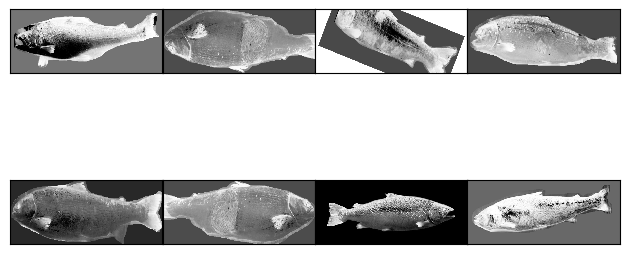

In [20]:
images, labels = next(iter(train_loader))
plot_images(images[:8], n_rows=2)

**Defining the CNN architecture**

In [21]:
# architecture of the CNN
class SalmonNet(nn.Module):
    def __init__(self):
        super(SalmonNet, self).__init__()

        self.convolutional_layer = nn.Sequential(

            # convolutional layer 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),

            # max pooling layer 1
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convolutional layer 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),

            # max pooling layer 2
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convolutional layer 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),

            # max pooling layer 3
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=128 * 31 * 75, out_features=128),
            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, x, verbose=False):
        x = self.convolutional_layer(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layer(x)
        return x

In [22]:
# check the shape of the output of the CNN
def test_Net_shapes():
    net = SalmonNet()
    net.to(device)

    with torch.no_grad():
        images, labels = next(iter(train_loader))
        images = images.to(device)
        print('Shape of the input tensor:', images.shape)

        y = net(images, verbose=True)
        print('Shape of the output tensor:', y.shape)

    print('Success')

test_Net_shapes()

Shape of the input tensor: torch.Size([16, 3, 250, 600])
Shape of the output tensor: torch.Size([16, 1])
Success


In [23]:
# instantiate a network model to be trained
net = SalmonNet()
net = net.to(device) # as specified in code cell 3

**Training the CNN model**

In [24]:
# a function for computing metrics on the val dataset
def compute_metrics(net, test_loader):
    net.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return accuracy, precision, recall, f1

In [25]:
# defining the loss function
pos_weight = torch.tensor([35/65]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# defining the optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-5)

# init collection of training epoch losses
train_losses = []

# setting the model in training mode
net.train()

SalmonNet(
  (convolutional_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=297600, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [26]:
# Implement the training loop
best_accuracy = 0.0
patience = 3
no_improvement = 0
epochs = 10

for epoch in range(epochs):

    # init the time
    time0 = time.time()

    # init collection of mini-batch losses
    running_loss=[]

    # iterate over all-mini batches
    for batch_idx, data in enumerate(train_loader,0):

        # push mini-batch data to computation device
        inputs,target = data
        inputs,target = inputs.to(device), target.to(device)

        # run forward pass through the network
        outputs = net(inputs, verbose=True)

        # reset graph gradients
        optimizer.zero_grad()

        # determine classification loss
        loss = criterion(outputs,target)

        # run backward pass to update the weights
        loss.backward()

        # update network paramaters
        optimizer.step()

        # collect mini-batch reconstruction loss
        running_loss.append(loss.item())

    # determine mean min-batch loss of epoch
    train_loss = np.mean(running_loss)
    train_losses.append(train_loss)

    # Calculate validation metrics
    train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(net, test_loader)

    # saving the best model
    if train_accuracy > best_accuracy:
        best_accuracy = train_accuracy
        model_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/SalmonScan', 'best_salmon_model.pth')
        torch.save(net.state_dict(), model_path)
        print(f"New best model saved with accuracy: {train_accuracy:.3f}")
        no_improvement = 0
    else:
        no_improvement += 1

    # Printing epoch loss and metrics
    if epoch % 1 == 0:
        print(
            f"epoch:{epoch+1}",
            "\ttrain_loss:",
            round(train_loss, 3),
            "\taccuracy:",
            round(train_accuracy, 3),
            "\tprecision:",
            round(train_precision, 3),
            "\trecall:",
            round(train_recall, 3),
            "\tF1:",
            round(train_f1, 3),
            "\tUsed_time:",
            round((time.time() - time0) / 60, 3)
        )

    # early stopping check
    if no_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

New best model saved with accuracy: 0.902
epoch:1 	train_loss: 2.777 	accuracy: 0.902 	precision: 0.933 	recall: 0.906 	F1: 0.919 	Used_time: 0.141
epoch:2 	train_loss: 1.053 	accuracy: 0.902 	precision: 0.899 	recall: 0.947 	F1: 0.922 	Used_time: 0.125
New best model saved with accuracy: 0.935
epoch:3 	train_loss: 0.179 	accuracy: 0.935 	precision: 0.943 	recall: 0.951 	F1: 0.947 	Used_time: 0.156
epoch:4 	train_loss: 0.085 	accuracy: 0.927 	precision: 0.935 	recall: 0.947 	F1: 0.941 	Used_time: 0.126
epoch:5 	train_loss: 0.061 	accuracy: 0.909 	precision: 0.952 	recall: 0.898 	F1: 0.924 	Used_time: 0.132
epoch:6 	train_loss: 0.049 	accuracy: 0.932 	precision: 0.929 	recall: 0.963 	F1: 0.946 	Used_time: 0.127
Early stopping at epoch 5


<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3524672106.py:13: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)


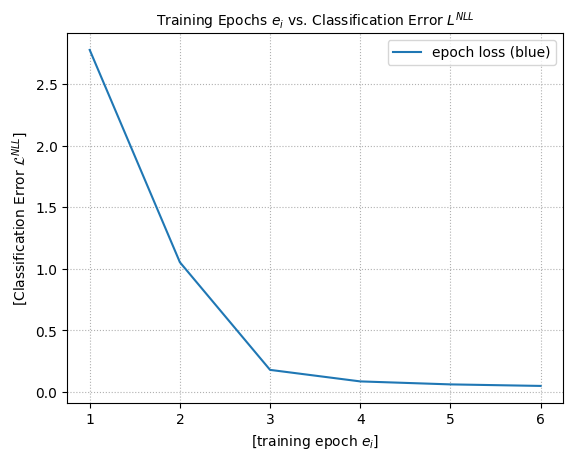

In [27]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_losses)+1)), train_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

**Evaluating the CNN model**

In [28]:
# loading the best model
model = SalmonNet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [29]:
# setting them model in evaluation mode
model.eval

<bound method Module.eval of SalmonNet(
  (convolutional_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=297600, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)>

Predicted Probability: 1.0000
Predicted Label: 1
Predicted Class: InfectedFish


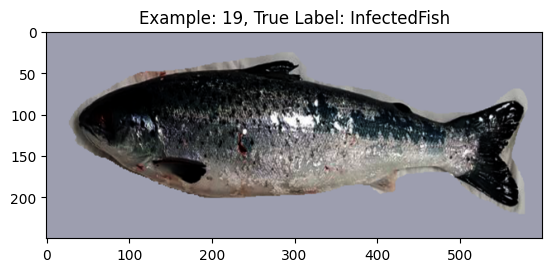

In [30]:
# Set a random image ID
image_id = 19 # You can choose any valid index from your test dataset

# Retrieve the image and label using the image ID
eval_image, eval_label = test_dataset[image_id]

# Convert eval_label to an integer
eval_label = int(eval_label.item()) if hasattr(eval_label, 'item') else int(eval_label)

# Define the classes for your dataset
classes = ["FreshFish", "InfectedFish"]

# Set image plot title
plt.title(f'Example: {image_id}, True Label: {classes[eval_label]}')

# Convert the image tensor to a PIL image for display
trans = torchvision.transforms.ToPILImage()

# Plot the image
plt.imshow(trans(eval_image))

# Predict the label of the image
eval_image_tensor = eval_image.unsqueeze(0).cpu()  # Add batch dimension and move to device
with torch.no_grad():
    output = model(eval_image_tensor)
    predicted_prob = torch.sigmoid(output).item()
    predicted_label = 1 if predicted_prob > 0.5 else 0

print(f'Predicted Probability: {predicted_prob:.4f}')
print(f'Predicted Label: {predicted_label}')
print(f'Predicted Class: {classes[predicted_label]}')

In [31]:
# storing the predicted classes on the test dataset
true_labels = []
predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

In [32]:
# calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# print the results
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')

Accuracy: 0.917
Precision: 0.921
Recall: 0.947
F1-Score: 0.934


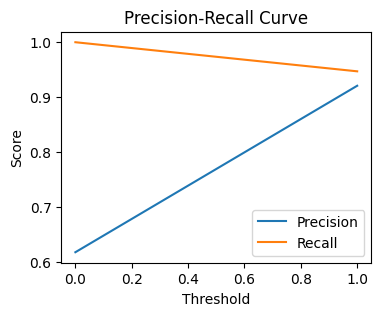

In [33]:
# Assuming you have true_labels and predicted_probs from your test set
precision, recall, thresholds = precision_recall_curve(true_labels, predictions)

# Plot precision and recall vs. threshold
plt.figure(figsize=(6, 5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()

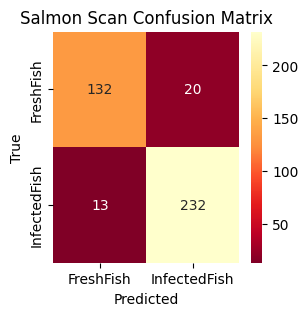

In [34]:
# inspecting the confusion matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd_r',
            xticklabels=["FreshFish", "InfectedFish"],
            yticklabels=["FreshFish", "InfectedFish"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Salmon Scan Confusion Matrix')
plt.show()